**Author**:  Sean Henely

**Purpose**:  Looks for times when the satellite will be in the SAA over the next 24 hours.  By default, blackout windows are searched from midnight to midnight; this can be configured.  Outputs a set of commands to schedule the blackout windows in Yavin Command Queue and Vega Pass Plan formats.

### Inputs

In [1]:
name = "SkySat-A"

### Imports

In [2]:
%pylab inline 

import httplib
import json
import datetime

import numpy
from matplotlib import pyplot

from saa_location import saa_happy, saa_scary, saa_really_scary

Populating the interactive namespace from numpy and matplotlib


### Constants

In [3]:
JANUS_HOST = 'janus.prod.pdx1.skybox.com'

OSIRIS_REST_API = "/osiris-rest-api/v1/%s/%s?%s"

SUBSAT_LAT_LON = "subsat-lat-lon"

DAY = datetime.timedelta(days=1)
HOUR = datetime.timedelta(hours=1)

MIDNIGHT = datetime.time()

### Date/Time

In [4]:
#Default is to go from now until one day in the future
#XXX:  DO NOT CHANGE!!! If you know what you're doing, comment these two lines out...
start = datetime.datetime.combine(datetime.datetime.utcnow().date(),MIDNIGHT) + DAY
end = start + DAY + 12 * HOUR

#... and uncomment these two to set up a custom date range
#start = "2015-05-20T00:00:00Z"
#end = "2015-05-21T00:00:00Z"

start_time = start.strftime("%Y-%m-%dT%H:%M:%S.%fZ") \
             if isinstance(start,datetime.datetime) else \
             start
end_time = end.strftime("%Y-%m-%dT%H:%M:%S.%fZ") \
           if isinstance(end,datetime.datetime) else \
           end

print start_time,end_time

2016-03-08T00:00:00.000000Z 2016-03-09T12:00:00.000000Z


### Query Osiris for Sub-satellite Positions

In [5]:
conn = httplib.HTTPConnection(JANUS_HOST,8082)

request = [("satellite","%s",name),
           ("time-system","%s","UTC"),
           ("start-time","%s",start_time),
           ("end-time","%s",end_time),
           ("time-step-sec","%d",30)]
query = {"units": "DEG"}

osiris_request = "/".join([("%s/%s" % (key,format)) % value \
                           for key,format,value in request])

osiris_query = "&".join(["%s=%s" % (key, value) \
                         for key,value in query.iteritems()])
    
conn.request("GET",OSIRIS_REST_API % (osiris_request,SUBSAT_LAT_LON,osiris_query))

position_response = conn.getresponse()

if position_response.status == httplib.OK:
    positions = json.loads(position_response.read())["subsat_positions"]
    
    #Need time in both SatelliteTime and datetime
    datetime_array = numpy.array(map(lambda t: \
                                     datetime.datetime.strptime(t,"%Y-%m-%dT%H:%M:%S.%fZ"),
                                     [position["time"] \
                                      for position in positions]))
    
    #time_array = numpy.array([SatelliteTime(position["time"],"UTC") \
    #                          for position in positions])
    #datetime_array = numpy.array(map(lambda t: t.datetime,time_array))
    
    #Better idea to split up lat/lon into separate arrays
    lat_array = numpy.array([position["subposition"][0] \
                             for position in positions])
    lon_array = numpy.array([position["subposition"][1] \
                             for position in positions])
        
conn.close()

### Determine Enter/Exit Times to/from the SAA

In [6]:
def point_in_polygon(lat,lon,poly):
    """Even-odd algorith adapted from Orbit Location"""
    
    #x = lattitude
    #y = longitude for SAA
    n = len(poly)
    inside = False

    p1y,p1x = poly[0]
    for i in range(n+1):
        p2y,p2x = poly[i % n]
        if lon > min(p1y,p2y):
            if lon <= max(p1y,p2y):
                if lat <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (lon-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or lat <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

#Boolean array of if satellite is in the SAA
inside_flags = [point_in_polygon(lat_array[i],
                                 lon_array[i],
                                 saa_really_scary) \
                for i in range(len(datetime_array))]

#Enters if the previous was outside and the current is inside
enter_times = [datetime_array[i-1] \
               for i in range(1,len(inside_flags)-1) \
               if inside_flags[i] and not inside_flags[i-1] and \
                  i+1 != len(inside_flags)-1]


#Exits if the next will be outside and the current is inside
exit_times = [datetime_array[i+1] \
              for i in range(1,len(inside_flags)-1) \
              if inside_flags[i] and not inside_flags[i+1] and \
                 i != 0]    

### Plot Activity around the SAA

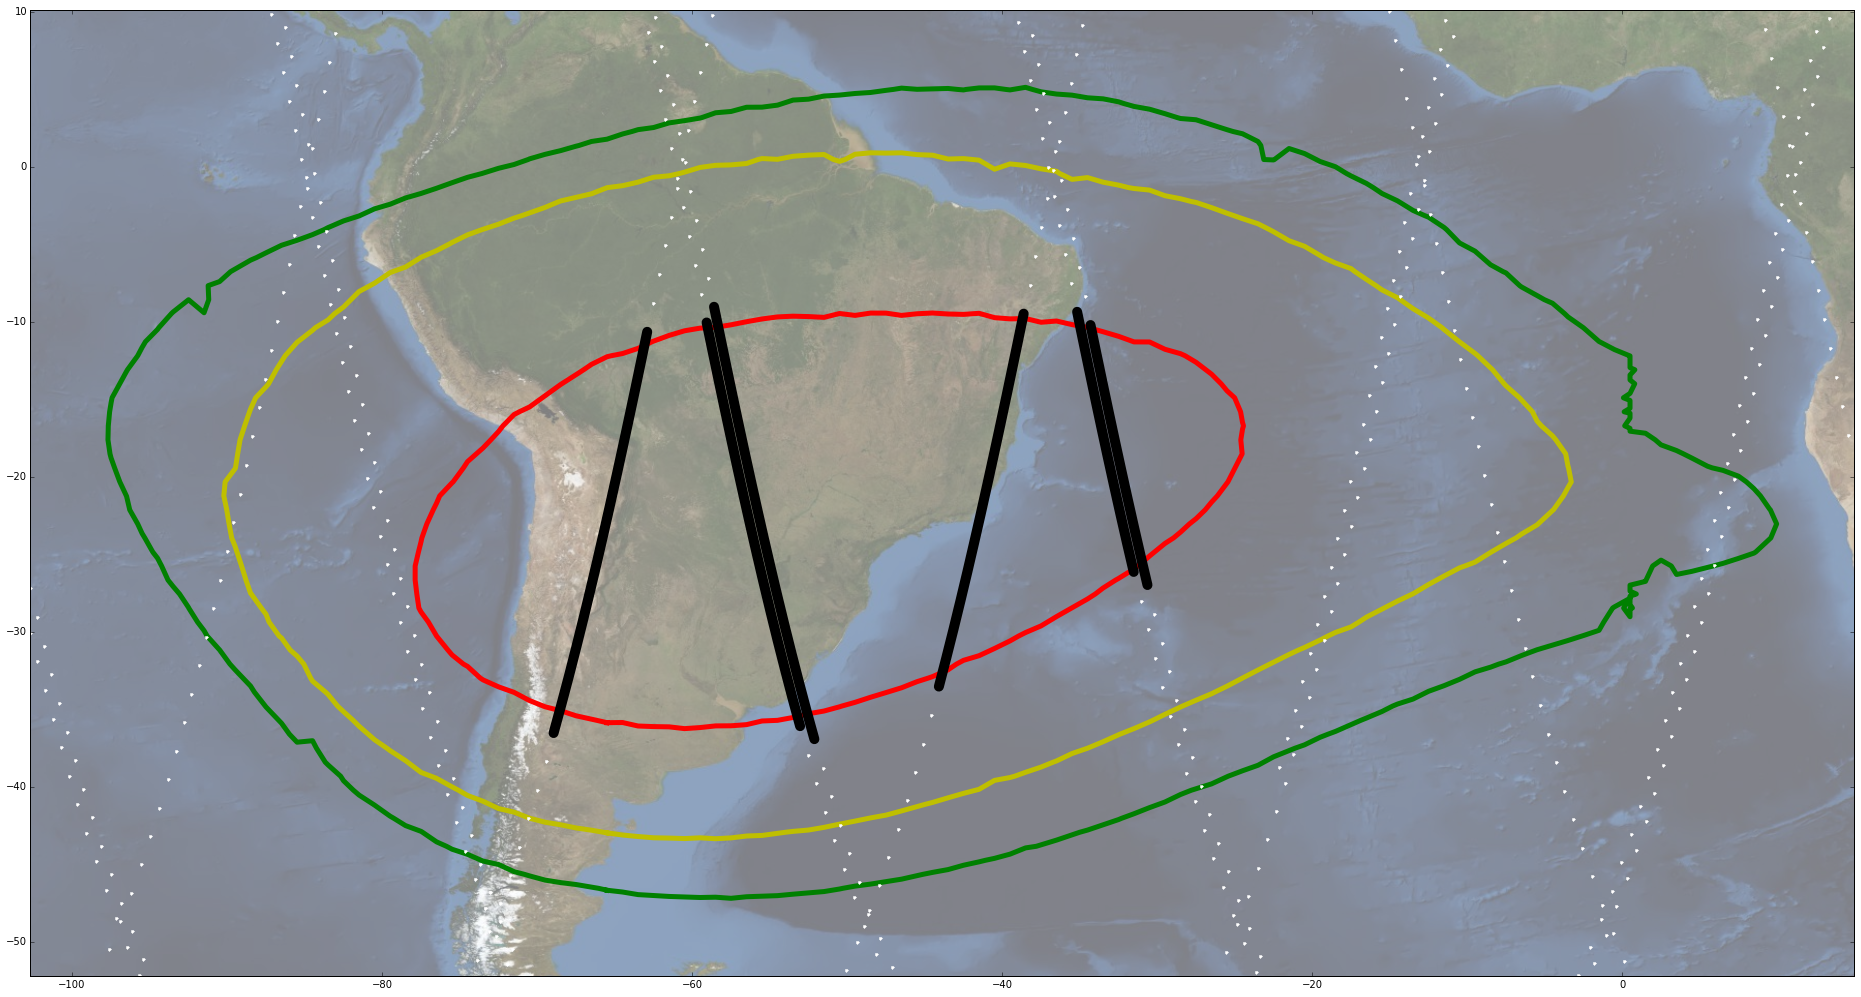

In [7]:
#Make the SAA arrays NumPy-compatible
happy_array = numpy.array(saa_happy)
scary_array = numpy.array(saa_scary)
really_scary_array = numpy.array(saa_really_scary)

#Zoom in the plot to the SAA
xmin,xmax = min(happy_array[:,0])-5, max(happy_array[:,0])+5
ymin,ymax = min(happy_array[:,1])-5, max(happy_array[:,1])+5

matplotlib.rcParams['figure.figsize'] = [100 * (xmax-xmin) / 360, 100 * (ymax-ymin) / 180]

imshow(imread('world.topo.bathy.200407.3x5400x2700.png'),
       extent=[-180, 180, -90, 90], alpha=0.5)

xlim(xmin, xmax)
ylim(ymin, ymax)

#Plot the SAA contours
pyplot.plot(happy_array[:,0], happy_array[:,1], "g", linewidth=5)
pyplot.plot(scary_array[:,0], scary_array[:,1], "y", linewidth=5)
pyplot.plot(really_scary_array[:,0], really_scary_array[:,1], "r", linewidth=5)

#Plot the satellite's ground track
pyplot.plot(lon_array, lat_array, "w.")

#Emphasize the ground track during each blackout window
for i in range(len(enter_times)):
    flags = (datetime_array >= enter_times[i]) & \
            (datetime_array <= exit_times[i])
    pyplot.plot(numpy.extract(flags,lon_array), 
                numpy.extract(flags,lat_array), "k",
                linewidth=10, solid_capstyle="round")

### Generate Yavin Command Queue

In [8]:
#Generate the command queue for scheduling blackout windows
command_queue = [{"name": "gnd_ReserveBlackoutWindow.py",
                  "command": [",".join(map(lambda sattime: sattime.strftime("%Y-%m-%dT%H:%M:%SZ"),
                                           enter_times)),
                              ",".join(map(lambda sattime: sattime.strftime("%Y-%m-%dT%H:%M:%SZ"),
                                           exit_times)),
                              ",".join(["NONE"] * len(enter_times)),
                              ",".join(["ACTIVITY"] * len(enter_times)),
                              "FALSE"]}]

print json.dumps(command_queue, indent=4)

[
    {
        "command": [
            "2016-03-08T01:14:30Z,2016-03-08T02:48:00Z,2016-03-08T13:25:30Z,2016-03-08T15:02:00Z,2016-03-09T01:17:30Z,2016-03-09T02:51:00Z", 
            "2016-03-08T01:19:00Z,2016-03-08T02:55:30Z,2016-03-08T13:32:00Z,2016-03-08T15:09:00Z,2016-03-09T01:22:00Z,2016-03-09T02:58:00Z", 
            "NONE,NONE,NONE,NONE,NONE,NONE", 
            "ACTIVITY,ACTIVITY,ACTIVITY,ACTIVITY,ACTIVITY,ACTIVITY", 
            "FALSE"
        ], 
        "name": "gnd_ReserveBlackoutWindow.py"
    }
]


### Generate Vega Pass Plan

In [9]:
pass_plan = {"description": "Schedule BOW around SAA",
             "steps": [{"summary": "Reserve Blackout Window",
                        "details": "Schedule a set of Blackout Windows that cover the SAA.",
                        "pops": [{"name": "gnd_ReserveBlackoutWindow.py",
                                  "arguments": [{"variable": "start_times",
                                                 "value": ",".join(map(lambda sattime: sattime.strftime("%Y-%m-%dT%H:%M:%SZ"),
                                                                       enter_times)) },
                                                {"variable": "end_times",
                                                 "value": ",".join(map(lambda sattime: sattime.strftime("%Y-%m-%dT%H:%M:%SZ"),
                                                                       exit_times)) },
                                                {"variable": "window_types",
                                                 "value": ",".join(["NONE"] * len(enter_times)) },
                                                {"variable": "seq_nums",
                                                 "value": ",".join(["ACTIVITY"] * len(enter_times)) },
                                                {"variable": "verbose",
                                                 "value": "FALSE"}]}]}]}

print json.dumps(pass_plan, indent=4)

{
    "steps": [
        {
            "pops": [
                {
                    "name": "gnd_ReserveBlackoutWindow.py", 
                    "arguments": [
                        {
                            "variable": "start_times", 
                            "value": "2016-03-08T01:14:30Z,2016-03-08T02:48:00Z,2016-03-08T13:25:30Z,2016-03-08T15:02:00Z,2016-03-09T01:17:30Z,2016-03-09T02:51:00Z"
                        }, 
                        {
                            "variable": "end_times", 
                            "value": "2016-03-08T01:19:00Z,2016-03-08T02:55:30Z,2016-03-08T13:32:00Z,2016-03-08T15:09:00Z,2016-03-09T01:22:00Z,2016-03-09T02:58:00Z"
                        }, 
                        {
                            "variable": "window_types", 
                            "value": "NONE,NONE,NONE,NONE,NONE,NONE"
                        }, 
                        {
                            "variable": "seq_nums", 
                            "v